In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  5 16:32:01 2018

@author: buck06191
"""

import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import string
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from PIL import Image
import io
import os
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300


def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale

def setAxLinesBW(ax):
    """
    Take each Line2D in the axes, ax, and convert the line style to be
    suitable for black and white viewing.
    """
    MARKERSIZE = 3

    COLORMAP = {
        'b': {'marker': None, 'dash': (None,None)},
        'g': {'marker': None, 'dash': [5,5]},
        'r': {'marker': None, 'dash': [5,3,1,3]},
        'c': {'marker': None, 'dash': [1,3]},
        'm': {'marker': None, 'dash': [5,2,5,2,5,10]},
        'y': {'marker': None, 'dash': [5,3,1,2,1,10]},
        'k': {'marker': 'o', 'dash': (None,None)} #[1,2,1,10]}
        }


    lines_to_adjust = ax.get_lines()
    try:
        lines_to_adjust += ax.get_legend().get_lines()
    except AttributeError:
        pass

    for line in lines_to_adjust:
#         if line.get_label()[:3] != "Q10":
#             continue
        origColor = line.get_color()
        line.set_color('black')
        line.set_dashes(COLORMAP[origColor]['dash'])
        line.set_marker(COLORMAP[origColor]['marker'])
        line.set_markersize(MARKERSIZE)
    
    return lines_to_adjust

def setFigLinesBW(fig):
    """
    Take each axes in the figure, and for each line in the axes, make the
    line viewable in black and white.
    """
    fig_label = ["({})".format(s) for s in list(string.ascii_lowercase)]
    for jj, ax in enumerate(fig.get_axes()):
        lines = setAxLinesBW(ax)
        ax.set_title(fig_label[jj], loc='left')

    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, 'upper left', prop={'size': 14}, bbox_to_anchor=(0.91, 0.91))
    

def save_as_tiff(fig, fname):
    # Save the image in memory in PNG format
    png1 = io.BytesIO()
    fig.savefig(png1, format="png", bbox_inches='tight')

    # Load this image into PIL
    png2 = Image.open(png1)

    # Save as TIFF
    png2.save("../Figures/{}.tiff".format(fname))
    print("saved Tiff")
    png1.close()
    
def get_autoregulation_json_data(model, output, direction):    
    data_dir = "../data/steady_state/{}/autoregulation/".format(model)
    with open(os.path.join(data_dir, '{}_{}.json'.format(output, direction)), 'r') as f:
        jsondata = json.load(f)

    return jsondata

def get_outputs_json_data(model, direction):    
    data_dir = "../data/steady_state/{}/model_output/".format(model)
    with open(os.path.join(data_dir, 'q_range_runs_{}.json'.format(direction)), 'r') as f:
        jsondata = json.load(f)
    
    return jsondata



## Blood Pressure

In [2]:
def generate_SS_figure_combo(model):
    xlabels = {"P_a": "Arterial Blood\nPressure (mmHg)",
              "SaO2sup": 'Arterial Oxygen\nSaturation (%)',
              "Pa_CO2": 'Partial Pressure\nof CO$_2$ (mmHg)'}
    outputs = list(xlabels.keys())
    directions=['down', 'up']
    fig, axes = plt.subplots(nrows=2, ncols=len(outputs), sharey=True, sharex='col', figsize=(8,6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    n = len(outputs)
    for ix in [(i,j) for i in range(2) for j in range(3)]: 
        direction = directions[ix[0]]
        output = outputs[ix[1]]
        ax = axes[ix]
        jsondata = get_autoregulation_json_data(model, output, direction)
        keys = list(jsondata.keys())
        keys.sort()
        

        for idx, k in enumerate(keys):
            if output == 'SaO2sup':
                jsondata[k][output] = [i*100 for i in jsondata[k][output]]
            axes[ix].plot(jsondata[k][output], jsondata[k]['CBF'], label='%s$^\circ$C'%k, c=colors[idx], alpha=0.6)
            
        axes[ix].set_title("{})".format(string.ascii_lowercase[3*ix[0]+ix[1]]), loc="left")
        if ix[0]==1:
            axes[ix].set_xlabel(xlabels[output], size=12)
        else:
            axes[ix].set_xlabel('')
        
        
        for item in (axes[ix].get_xticklabels() + axes[ix].get_yticklabels()):
            item.set_fontsize(12)
        
    axes[0,0].set_ylabel('Cerebral Blood Flow\n($ml_{blood}ml_{brain}^{-1}s^{-1}$)', size=12)
    axes[1,0].set_ylabel('Cerebral Blood Flow\n($ml_{blood}ml_{brain}^{-1}s^{-1}$)', size=12)
    axes.flatten()[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
    plt.tight_layout()
    
    fig.savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/{}/combo_{}_autoreg.png".format(
    model,model), transparent=True)
    return fig

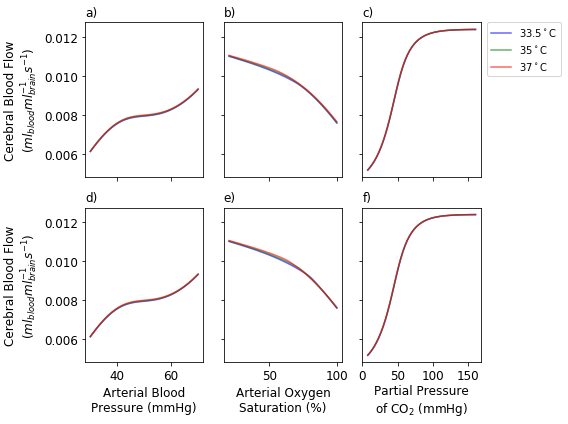

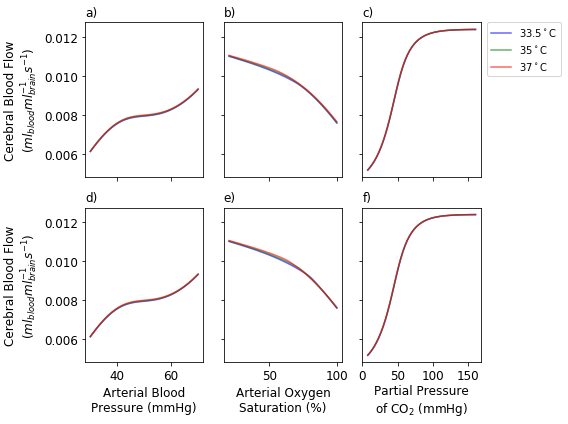

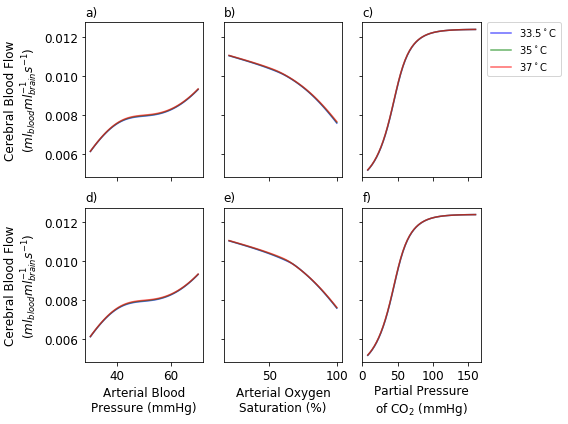

In [3]:
bph1_ar_fig = generate_SS_figure_combo("bp_hypothermia_1")
bph2_ar_fig = generate_SS_figure_combo("bp_hypothermia_2")
bph3_ar_fig = generate_SS_figure_combo("bp_hypothermia_4")


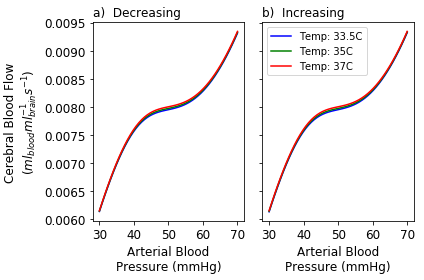

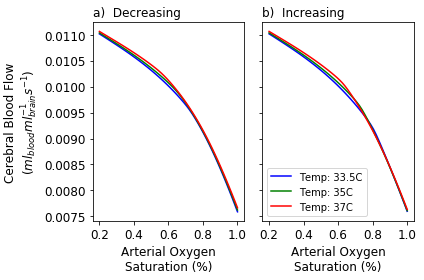

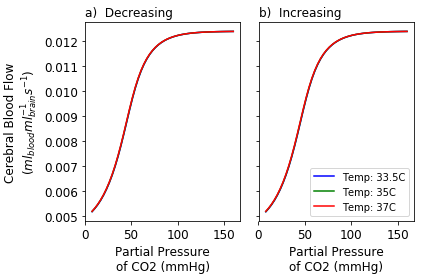

In [4]:
def generate_SS_figure(output, model, xlabel="", legend_loc="upper left"):
    title={'down': 'Decreasing', 'up': 'Increasing'}
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ix, direction in enumerate(["down", "up"]): 
        jsondata = get_autoregulation_json_data(model, output, direction)
        keys = list(jsondata.keys())
        keys.sort()
        data = jsondata[keys[0]][output]

        for idx, k in enumerate(keys):
            axes[ix].plot(jsondata[k][output], jsondata[k]['CBF'], label='Temp: %sC'%k, c=colors[idx])
            
        axes[ix].set_title("{})  {}".format(string.ascii_lowercase[ix], title[direction]), loc="left")  
        axes[ix].set_xlabel(xlabel, size=12)
        

        for item in (axes[ix].get_xticklabels() + axes[ix].get_yticklabels()):
            item.set_fontsize(12)
        
    axes[0].set_ylabel('Cerebral Blood Flow\n($ml_{blood}ml_{brain}^{-1}s^{-1}$)', size=12)
    axes[1].legend(loc=legend_loc, fontsize=10)
    plt.tight_layout()
    
    fig.savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/{}/{}_{}_autoreg.png".format(
    model,output,model), transparent=True)
    return fig
    
pa_fig = generate_SS_figure("P_a", "bp_hypothermia_1", "Arterial Blood\nPressure (mmHg)")

sao2_fig = generate_SS_figure("SaO2sup", "bp_hypothermia_1", 'Arterial Oxygen\nSaturation (%)', legend_loc="lower left")

paco2_fig = generate_SS_figure("Pa_CO2", "bp_hypothermia_1", 'Partial Pressure\nof CO2 (mmHg)', legend_loc="lower right")

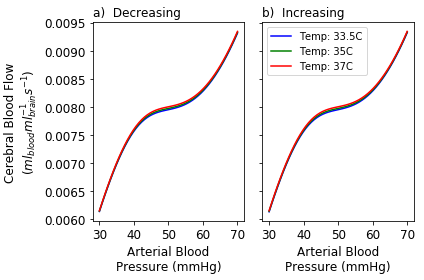

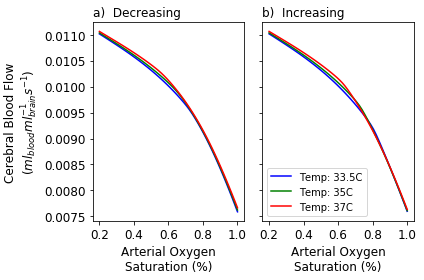

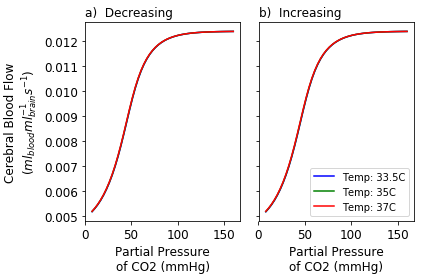

In [5]:
pa_fig_2 = generate_SS_figure("P_a", "bp_hypothermia_2", "Arterial Blood\nPressure (mmHg)")

sao2_fig_2 = generate_SS_figure("SaO2sup", "bp_hypothermia_2", 'Arterial Oxygen\nSaturation (%)', legend_loc="lower left")

paco2_fig_2 = generate_SS_figure("Pa_CO2", "bp_hypothermia_2", 'Partial Pressure\nof CO2 (mmHg)', legend_loc="lower right")

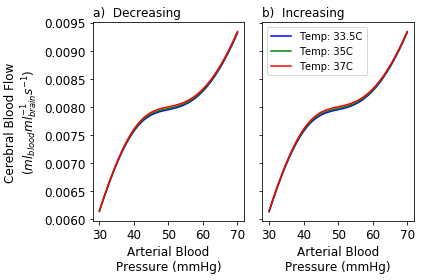

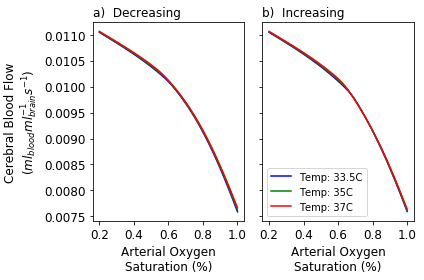

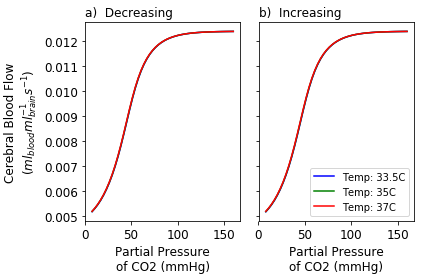

In [6]:
pa_fig_3 = generate_SS_figure("P_a", "bp_hypothermia_4", "Arterial Blood\nPressure (mmHg)")

sao2_fig_3 = generate_SS_figure("SaO2sup", "bp_hypothermia_4", 'Arterial Oxygen\nSaturation (%)', legend_loc="lower left")

paco2_fig_3 = generate_SS_figure("Pa_CO2", "bp_hypothermia_4", 'Partial Pressure\nof CO2 (mmHg)', legend_loc="lower right")

## Model output visualisation ##

In [7]:
bp2_data = get_outputs_json_data(model="bp_hypothermia_2", direction="down")
bp3_data = get_outputs_json_data(model="bp_hypothermia_4", direction="down")

In [8]:
bp1_data = get_outputs_json_data(model="bp_hypothermia_1", direction="down")


In [9]:
title = {"CBF": "CBF", "CCO": "$\Delta$ oxCCO","CMRO2": "CMRO$_{2}$", "TOI": "TOI", "Hbdiff": "$\Delta$ HbD"}
units = {'Hbdiff': "$\mu M$", 'CCO': "$\mu M$", "CBF" : "% of baseline", "CMRO2": "% of baseline", "TOI": "%" }
def parse_json_data(json_data):
    parsed_data={}
    for k, v in json_data.items():
        params = tuple(map(lambda x: round(float(x),2), k.split('_')))
        parsed_data[params] = {output: data[-1] for output, data in v.items()}
    
    return parsed_data

def get_cols_and_rows(parsed_json_data):
    """
    Get set of col and rows from json keys.
    
    Return
    ======
    
    cols, rows : sets of the param values
    """
    rows = []
    cols = []
    for k in parsed_json_data.keys():
        rows.append(k[0])
        cols.append(k[1])
    return sorted(set(cols)), sorted(set(rows))
        
def create_dataframe(parsed_json_data):
    cols, rows = get_cols_and_rows(parsed_json_data)
    df = pd.DataFrame(index=rows, columns=cols)
    return df

def get_baseline_cmro2(json_data):
    parsed_data={}
    for k, v in json_data.items():
        params = tuple(map(lambda x: round(float(x),2), k.split('_')))
        parsed_data[params] = {output: data[-1]/data[0] * 100 for output, data in v.items()}
    
    return parsed_data

def get_baseline_NIRS(json_data):
    parsed_data={}
    for k, v in json_data.items():
        params = tuple(map(lambda x: round(float(x),2), k.split('_')))
        parsed_data[params] = {output: data[-1]-data[0] for output, data in v.items()}
    
    return parsed_data
    
    
def fill_dataframe(json_data, output):
    
    if output == "CMRO2" or output == "CBF":
        parsed_json_data = get_baseline_cmro2(json_data)
    elif output == "Hbdiff" or output == "CCO":
        parsed_json_data = get_baseline_NIRS(json_data)
    else:
        parsed_json_data = parse_json_data(json_data)
    df = create_dataframe(parsed_json_data)
    for k, v in parsed_json_data.items():
        df.loc[k] = v[output]
    return df
        
def get_output_heatmap(json_data, output, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(1, figsize = (4,3.5))
    df = fill_dataframe(json_data, output)
    if output == "CCO" or output == "Hbdiff":
        sns.heatmap(df.apply(pd.to_numeric), ax=ax, cmap="RdBu_r", center=0, vmin= df.values.min(), vmax= df.values.max(),
                    cbar_kws={'label': '{} ({})'.format(title[output], units[output])})
    else:    
        sns.heatmap(df.apply(pd.to_numeric), ax=ax, cmap="BuPu", vmin= df.values.min(), vmax= df.values.max(),
                        cbar_kws={'label': '{} ({})'.format(title[output], units[output])})
    ax.set_title(title[output])
    if xlabel:
        ax.set_xlabel(xlabel, size=12)
    if ylabel: 
        ax.set_ylabel(ylabel, size=12)
    plt.tight_layout()
    return df, fig

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap



def get_output_timeseries(json_data, output, xlabel=None, ylabel=None):
    fig = plt.figure(figsize=(4,3.5))
    ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=4, colspan=3, fig=fig)
    ax2 = plt.subplot2grid((4, 4), (0, 3), rowspan=4, fig=fig)
    n = len(json_data.keys())
    Q10 = np.arange(0.1, 5.1, 0.1)
    colors = plt.cm.get_cmap('nipy_spectral')(np.linspace(0.,1,n))
    cmap = truncate_colormap(plt.cm.get_cmap('nipy_spectral'), 0., 1)
    norm = mpl.colors.Normalize(vmin=0.1, vmax=5.)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label('$Q_{10}$')
    i=0
    for k,v in json_data.items():
        if output == "CMRO2" or output == "CBF":
            v[output] = [i/v[output][0] * 100 for i in v[output]]
        ax1.plot(v['temp'], v[output], label=k, color=colors[i])
        i+=1
    
    ax1.set_title(title[output])
    if xlabel:
        ax1.set_xlabel(xlabel, size=12)
    if ylabel: 
        ax1.set_ylabel(ylabel, size=12)
    # fig.colorbar(plt.cm.ScalarMappable(norm = pltcol.Normalize(vmin=0.1, vmax=5), cmap=plt.cm.get_cmap('BuPu')))
    plt.tight_layout()
    return fig

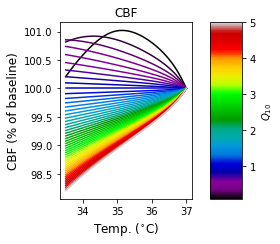

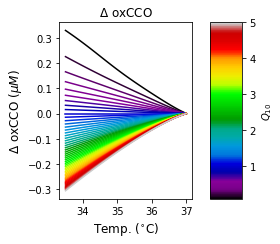

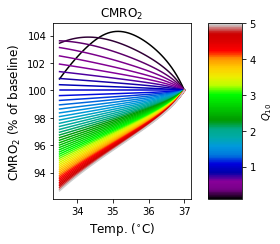

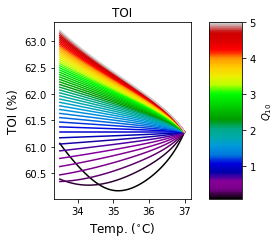

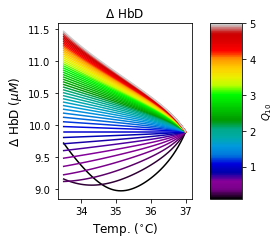

In [10]:
for output in title.keys():
    g = get_output_timeseries(bp1_data, output, xlabel="Temp. ($^{\circ}$C)", ylabel="{} ({})".format(title[output], units[output]) )
    g.savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/bp_hypothermia_1/{}_bph1_outputs.png".format(output), transparent=True)


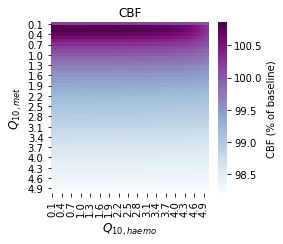

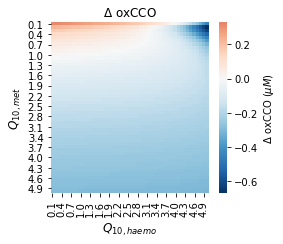

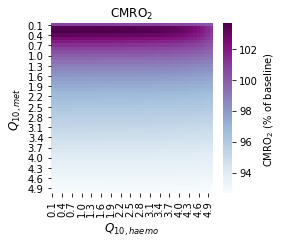

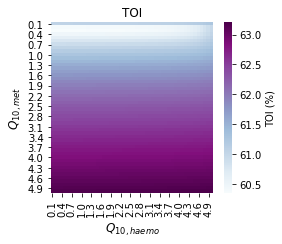

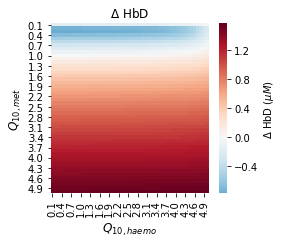

In [11]:
for output in title.keys():
    df, g = get_output_heatmap(bp2_data, output, xlabel="$Q_{10, haemo}$", ylabel="$Q_{10,met}$" )
    g# .savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/bp_hypothermia_2/{}_bph2_outputs.png".format(output), transparent=True)

## Initial Notes ##

BPH4 with $q_{diff} > 1$ produces no change - odel becomes insensitive to further changes.

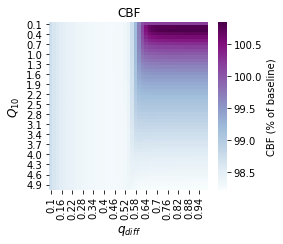

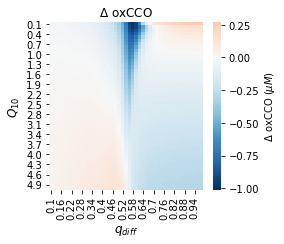

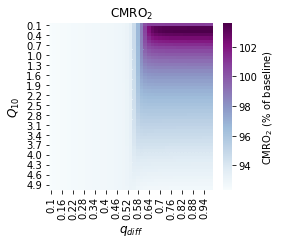

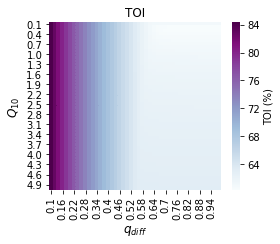

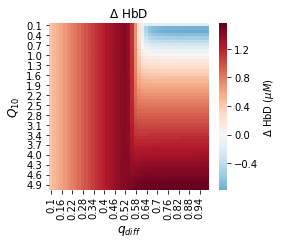

In [12]:
for output in title.keys():
    df, g = get_output_heatmap(bp3_data, output, xlabel="$q_{diff}$", ylabel="$Q_{10}$" )
    g.savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/bp_hypothermia_4/{}_bph3_outputs.png".format(output), transparent=True)

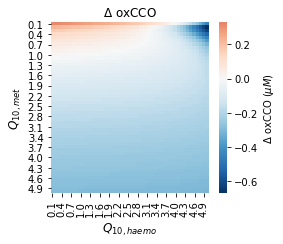

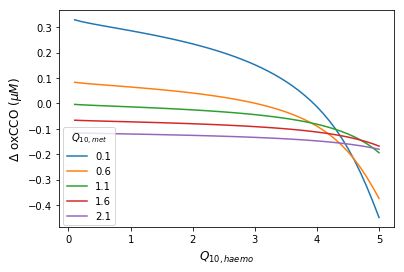

In [22]:
df_cco, _ = get_output_heatmap(bp2_data, 'CCO', xlabel="$Q_{10,haemo}$", ylabel="$Q_{10,met}$" )
fig, ax = plt.subplots(1)
for ix, d in enumerate(df_cco.values):
    if (ix % 5 == 0) & (ix<25):
        ax.plot(df_cco.columns, d, label=df_cco.index[ix])
fig.legend(title = "$Q_{10,met}$", loc=2, bbox_to_anchor=(0.135,0.52))
ax.set_xlabel("$Q_{10,haemo}$", size=12)
ax.set_ylabel("{} ({})".format(title['CCO'], units['CCO']), size=12)
fig.savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/bp_hypothermia_2/CCO_bph2_lines.png", transparent=True)

Text(0, 0.5, '$\\Delta$ oxCCO ($\\mu M$)')

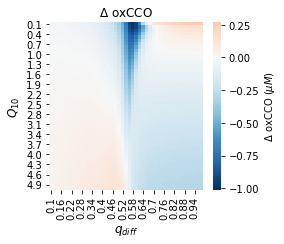

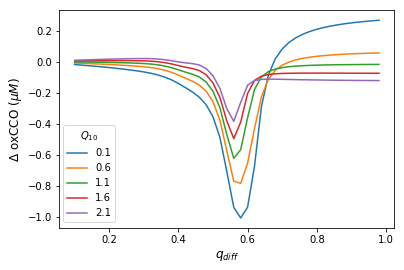

In [25]:
df_cco, _ = get_output_heatmap(bp3_data, 'CCO', xlabel="$q_{diff}$", ylabel="$Q_{10}$" )
fig, ax = plt.subplots(1)
for ix, d in enumerate(df_cco.values):
    if ix % 10 == 0:
        ax.plot(df_cco.columns, d, label=df_cco.index[ix])
fig.legend(title = "$Q_{10}$", loc=2, bbox_to_anchor=(0.135,0.52))
ax.set_xlabel("$q_{diff}$", size=12)
ax.set_ylabel("{} ({})".format(title['CCO'], units['CCO']), size=12)
fig.savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/bp_hypothermia_4/CCO_bph3_lines.png", transparent=True)

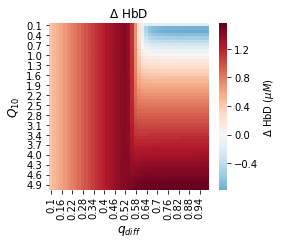

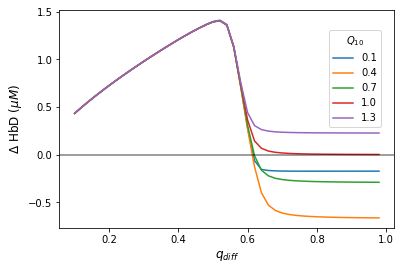

In [39]:
df_cco, _ = get_output_heatmap(bp3_data, 'Hbdiff', xlabel="$q_{diff}$", ylabel="$Q_{10}$" )
fig, ax = plt.subplots(1)
for ix, d in enumerate(df_cco.values):
    if (ix % 3 == 0) & (ix<15):
        ax.plot(df_cco.columns, d, label=df_cco.index[ix])
ax.axhline(0, color='k', alpha=0.5)
fig.legend(title = "$Q_{10}$", loc=2, bbox_to_anchor=(0.75,0.85))
ax.set_xlabel("$q_{diff}$", size=12)
ax.set_ylabel("{} ({})".format(title['Hbdiff'], units['Hbdiff']), size=12)
fig.savefig("/home/buck06191/Dropbox/phd/hypothermia/Figures/steady_state/model_comparisons/bp_hypothermia_4/HbD_bph3_lines.png", transparent=True)

KeyError: 'HbO2'

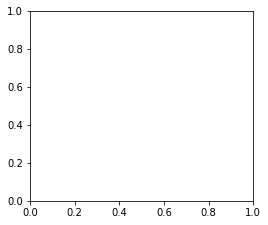

In [15]:
get_output_heatmap(bp2_data, 'HbO2')

In [ ]:
## Q10 figures
# with open('q10/220618T1154.json', 'r') as f:
jsondata_q10 = {}

jsondata_q10['down'] = get_outputs_json_data("bp_hypothermia_1", "down")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
outputs = ['TOI', 'CBF', 'Hbdiff', 'CCO', 'CMRO2']
units = ["(%)", "(% of baseline)", "($\mu M$)", "($\mu M$)", "(% of baseline)"]
keys = list(jsondata_q10['down'].keys())[:6]
ylims = {"up": {}, "down": {}}
# jsondata_q10['up'] = {k:{} for k in keys}
# jsondata_q10['down'] = {k: {} for k in keys}
# for k in keys:
#     jsondata_q10['up'][k] = {inner_k: jsondata_q10_all[k][inner_k][:len(jsondata_q10_all[k]['t']) // 2 + 1] for inner_k in jsondata_q10_all[k].keys()}
#     jsondata_q10['down'][k] = {inner_k: jsondata_q10_all[k][inner_k][len(jsondata_q10_all[k]['t']) // 2:] for inner_k in jsondata_q10_all[k].keys()}

print(keys)
keys.sort()
# fig, axes = plt.subplots(nrows=2, ncols=3)
for direction  in ['down']:
    for ii, o in enumerate(outputs):
        fig, ax = plt.subplots(1)
        print("\n{}\n".format(o))
        # ax = axes.flatten()[ii]
        for idx, k in enumerate(keys):
            if o == 'CBF' or o == 'CMRO2':
                print(k, ": ", jsondata_q10[direction][k][o][0])
                jsondata_q10[direction][k][o] = [100*(i/jsondata_q10[direction][k][o][0]) for i in jsondata_q10[direction][k][o]]
            # l = len(jsondata_q10[k]['t']) // 2
            ax.plot(jsondata_q10[direction][k]['temp'], jsondata_q10[direction][k][o], label='Q10 = %s'%k, c=colors[idx])
            max_idx = jsondata_q10[direction][k]['temp'].index(37)
#             for j, t in enumerate(jsondata_q10[direction][k]['temp']):
#                 if 33.4<t<33.6:
#                     min_idx = j
#                     break
            
#             if direction=="down":
#                 perc_change = jsondata_q10[direction][k][o][min_idx] / jsondata_q10[direction][k][o][max_idx] * 100
#                 print("From 37C to 33.5C {} changes to {:.1f}% of its starting value for Q10={}".format(o,perc_change,k))
#             elif direction=="up":
#                 perc_change = jsondata_q10[direction][k][o][max_idx] / jsondata_q10[direction][k][o][min_idx] * 100
#                 print("From 33.5C to 37C {} changes to {:.1f}% of its starting value for Q10={}".format(o,perc_change,k))
        ax.set_xlabel('Temperature ($^\circ$C)', size=16)
        if o=='CCO':
            ax.set_ylabel("$\Delta$oxCCO {}".format(units[ii]), size=16)
        elif o=='DHbdiff':
            ax.set_ylabel("$\Delta$HbD {}".format(units[ii]), size=16)
        elif o == "TOI":
            ax.set_ylabel("StO2 {}".format(units[ii]), size=16)
        else:
            ax.set_ylabel("{} {}".format(o, units[ii]), size=16)

        ax.set_title("{d}".format(d="Rewarming" if direction == "up" else "Cooling"), size=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.legend(prop={'size': 14})
        
        ylims[direction][o] = ax.get_ylim()


        plt.tight_layout()
        fname = "varying_Q10_{}_{}.png".format(o, direction)
plt.show()
print(ylims)
    
    

In [ ]:
## Q10 figures
# with open('q10/220618T1154.json', 'r') as f:
jsondata_q10 = {}

jsondata_q10['down'] = get_outputs_json_data("bp_hypothermia_1", "down")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
outputs = ['TOI', 'CBF', 'Hbdiff', 'CCO', 'CMRO2']
units = ["(%)", "(% of baseline)", "($\mu M$)", "($\mu M$)", "(% of baseline)"]
keys = list(jsondata_q10['down'].keys())[:6]
# jsondata_q10['up'] = {k:{} for k in keys}
# jsondata_q10['down'] = {k: {} for k in keys}
# for k in keys:
#     jsondata_q10['up'][k] = {inner_k: jsondata_q10_all[k][inner_k][:len(jsondata_q10_all[k]['t']) // 2 + 1] for inner_k in jsondata_q10_all[k].keys()}
#     jsondata_q10['down'][k] = {inner_k: jsondata_q10_all[k][inner_k][len(jsondata_q10_all[k]['t']) // 2:] for inner_k in jsondata_q10_all[k].keys()}

print(keys)
keys.sort()
# fig, axes = plt.subplots(nrows=2, ncols=3)
for direction  in ['down']:
    fig, axes = plt.subplots(nrows=2, ncols=3)
    for ii, o in enumerate(outputs):
        
        print("\n{}\n".format(o))
        ax = axes.flatten()[ii]
        for idx, k in enumerate(keys):
            if o == 'CBF' or o == 'CMRO2':
                print(k, ": ", jsondata_q10[direction][k][o][0])
                jsondata_q10[direction][k][o] = [100*(i/jsondata_q10[direction][k][o][0]) for i in jsondata_q10[direction][k][o]]
            # l = len(jsondata_q10[k]['t']) // 2
            # l = len(jsondata_q10[k]['t']) // 2
            ax.plot(jsondata_q10[direction][k]['temp'], jsondata_q10[direction][k][o], label='Q10 = %s'%k, c=colors[idx])
            max_idx = jsondata_q10[direction][k]['temp'].index(37)
            for j, t in enumerate(jsondata_q10[direction][k]['temp']):
                if 33.4<t<33.6:
                    min_idx = j
                    break
            
            if direction=="down":
                perc_change = jsondata_q10[direction][k][o][min_idx] / jsondata_q10[direction][k][o][max_idx] * 100
                print("From 37C to 33.5C {} changes to {:.1f}% of its starting value for Q10={}".format(o,perc_change,k))
            elif direction=="up":
                perc_change = jsondata_q10[direction][k][o][max_idx] / jsondata_q10[direction][k][o][min_idx] * 100
                print("From 33.5C to 37C {} changes to {:.1f}% of its starting value for Q10={}".format(o,perc_change,k))
        ax.set_xlabel('Temperature ($^\circ$C)', size=16)
        if o=='CCO':
            ax.set_ylabel("$\Delta$oxCCO {}".format(units[ii]), size=16)
        elif o=='DHbdiff':
            ax.set_ylabel("$\Delta$HbD {}".format(units[ii]), size=16)
        elif o == "TOI":
            ax.set_ylabel("StO2 {}".format(units[ii]), size=16)
        else:
            ax.set_ylabel("{} {}".format(o, units[ii]), size=16)

        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.locator_params(tight=True, nbins=4)
        ax.set_ylim(bottom = (ax.get_ylim()[0]-0.054)*0.9975, top=(ax.get_ylim()[1]+0.01)*1.0015)
        #ax.legend(prop={'size': 14})
        
    fig.delaxes(axes[-1,-1])

    #ax.axvline(33.5)
    # fig.suptitle("{d}".format(d="Rewarming" if direction == "up" else "Cooling"), size=18)
    fig.subplots_adjust(top=0.8)
    axes.flatten()[len(outputs)-1].legend(prop={'size': 14}, bbox_to_anchor=(0.95, 0.91))
    plt.tight_layout()
    fname = "varying_Q10_{}_combined".format(direction)

    # plt.savefig("E:/Dropbox/phd/Conferences/ISOTT-2018/Figures/{}".format(fname))

    
plt.show()
    
    

In [ ]:
## Q10 figures
# with open('q10/220618T1154.json', 'r') as f:
print(ylims)
jsondata_q10 = {}
with open('q10/020718T1013.json', 'r') as f:
    jsondata_q10['down'] = json.load(f)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
outputs = ['TOI', 'CBF', 'DHbdiff', 'CCO', 'CMRO2']
units = ["(%)", "(% of baseline)", "($\mu M$)", "($\mu M$)", "(% of baseline)"]
keys = list(jsondata_q10_all.keys())[:6]
# jsondata_q10['up'] = {k:{} for k in keys}
# jsondata_q10['down'] = {k: {} for k in keys}
# for k in keys:
#     jsondata_q10['up'][k] = {inner_k: jsondata_q10_all[k][inner_k][:len(jsondata_q10_all[k]['t']) // 2 + 1] for inner_k in jsondata_q10_all[k].keys()}
#     jsondata_q10['down'][k] = {inner_k: jsondata_q10_all[k][inner_k][len(jsondata_q10_all[k]['t']) // 2:] for inner_k in jsondata_q10_all[k].keys()}

print(keys)
keys.sort()
# fig, axes = plt.subplots(nrows=2, ncols=3)
for direction  in ['down']:
    for ii, o in enumerate(outputs):
        fig, ax = plt.subplots(1)
        print("\n{}\n".format(o))
        # ax = axes.flatten()[ii]
        for idx, k in enumerate(keys):
            if o == 'CBF' or o == 'CMRO2':
                jsondata_q10[direction][k][o] = [100*(i/jsondata_q10[direction][k][o][0]) for i in jsondata_q10[direction][k][o]]

            # l = len(jsondata_q10[k]['t']) // 2
            if k == '2.5':
                ax.plot(jsondata_q10[direction][k]['temp'], jsondata_q10[direction][k][o], label='Q10 = %s'%k, c=colors[idx])
            
        ax.set_xlabel('Temperature ($^\circ$C)', size=16)
        if o=='CCO':
            ax.set_ylabel("$\Delta$oxCCO {}".format(units[ii]), size=16)
        elif o=='DHbdiff':
            ax.set_ylabel("$\Delta$HbD {}".format(units[ii]), size=16)
        elif o == "TOI":
            ax.set_ylabel("StO2 {}".format(units[ii]), size=16)
        else:
            ax.set_ylabel("{} {}".format(o, units[ii]), size=16)

        #ax.set_title('Effect of decreasing temperature on {}\nfor varying Q10'.format(o), size=16)
        ax.set_title("{d}".format(d="Rewarming" if direction == "up" else "Cooling"), size=16)

        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.legend(prop={'size': 14})
        ax.set_ylim(ylims[direction][o])
    #fig.delaxes(axes[-1,-1])
        setFigLinesBW(fig)
        #ax.axvline(33.5)

        plt.tight_layout()
        fname = "Q10_2_5_{}_{}.png".format(o, direction)
        plt.savefig("/home/buck06191/Dropbox/phd/Conferences/ISOTT-2018/Figures/{}".format(fname))
plt.show()
    
    

In [ ]:
DHbd = jsondata_q10['up']['2.5']['DHbdiff']
CCO = jsondata_q10['up']['2.5']['CCO']
temp = jsondata_q10['up']['2.5']['temp']
for i in temp:
    if i >33.5:
        idx = temp.index(i)
        break
fig, ax = plt.subplots(1)
ax.plot(CCO[idx:], DHbd[idx:], '.k')
ax.axhline(0, color='k')
# set the x-spine (see below for more info on `set_position`)
ax.spines['right'].set_position('zero')

# turn off the right spine/ticks
ax.spines['left'].set_color('none')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')


#ax.set_ylim(ax.get_ylim()[0],0.02)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.set_xlabel("$\Delta$oxCCO ($\mu M$)", size=16)
ax.set_ylabel("$\Delta$HbD ($\mu M$)", size=16)



fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12,12))
ax[0].plot(temp[idx:], CCO[idx:], '.k')
ax[0].axhline(0, color='k')
ax[1].plot(temp[idx:], DHbd[idx:], '.k')
ax[1].axhline(0, color='k')


ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].set_ylabel("$\Delta$oxCCO ($\mu M$)", size=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_ylabel("$\Delta$HbD ($\mu M$)", size=16)
ax[1].set_xlabel('Temperature ($^\circ$C)', size=16)# # fig, axes = plt.subplots(nrows=2, ncols=3)

#plt.tight_layout()
# for ii, o in enumerate(outputs):
#     fig, ax = plt.subplots(1)
#     print("\n{}\n".format(o))
#     # ax = axes.flatten()[ii]

#     #l = len(jsondata_q10[k]['t']) // 2
#     ax.plot(jsondata_q10["2.5"]['temp'], jsondata_q10["2.5"][o], label='Q10 = %s'%k, c=colors[idx])
#     ax.set_xlabel('Temperature ($^\circ$C)', size=16)
#     if o=='CCO':
#         ax.set_ylabel("$\Delta$oxCCO {}".format(units[ii]), size=16)
#     elif o == "TOI":
#         ax.set_ylabel("StO2 {}".format(units[ii]), size=16)
#     else:
#         ax.set_ylabel("{} {}".format(o, units[ii]), size=16)

#     #ax.set_title('Effect of decreasing temperature on {}\nfor varying Q10'.format(o), size=16)
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     #ax.legend(prop={'size': 12})
# #fig.delaxes(axes[-1,-1])
#     setFigLinesBW(fig)
#     plt.tight_layout()
#     fname = "Q10_2_5_{}.png".format(o)
#     plt.savefig("/home/buck06191/Dropbox/phd/Conferences/ISOTT-2018/Figures/{}".format(fname))
plt.show()